Libraries

In [16]:
import numpy as np
import random
import math, random
import matplotlib.pyplot as plt

tai12a

In [17]:
# --- Distance Matrix ---
distance_matrix = np.array([
    [0, 27, 85, 2, 1, 15, 11, 35, 11, 20, 21, 61],
    [27, 0, 80, 58, 21, 76, 72, 44, 85, 94, 90, 51],
    [85, 80, 0, 3, 48, 29, 90, 66, 41, 15, 83, 96],
    [2, 58, 3, 0, 74, 45, 65, 40, 54, 83, 14, 71],
    [1, 21, 48, 74, 0, 77, 36, 53, 37, 26, 87, 76],
    [15, 76, 29, 45, 77, 0, 91, 13, 29, 11, 77, 32],
    [11, 72, 90, 65, 36, 91, 0, 87, 67, 94, 79, 2],
    [35, 44, 66, 40, 53, 13, 87, 0, 10, 99, 56, 70],
    [11, 85, 41, 54, 37, 29, 67, 10, 0, 99, 60, 4],
    [20, 94, 15, 83, 26, 11, 94, 99, 99, 0, 56, 2],
    [21, 90, 83, 14, 87, 77, 79, 56, 60, 56, 0, 60],
    [61, 51, 96, 71, 76, 32, 2, 70, 4, 2, 60, 0]
])

# --- Flow Matrix ---
flow_matrix = np.array([
    [0, 21, 95, 82, 56, 41, 6, 25, 10, 4, 63, 6],
    [21, 0, 44, 40, 75, 79, 0, 89, 35, 9, 1, 85],
    [95, 44, 0, 84, 12, 0, 26, 91, 11, 35, 82, 26],
    [82, 40, 84, 0, 69, 56, 86, 45, 91, 59, 18, 76],
    [56, 75, 12, 69, 0, 39, 18, 57, 36, 61, 36, 21],
    [41, 79, 0, 56, 39, 0, 71, 11, 29, 82, 82, 6],
    [6, 0, 26, 86, 18, 71, 0, 71, 8, 77, 74, 30],
    [25, 89, 91, 45, 57, 11, 71, 0, 89, 76, 76, 40],
    [10, 35, 11, 91, 36, 29, 8, 89, 0, 93, 56, 1],
    [4, 9, 35, 59, 61, 82, 77, 76, 93, 0, 50, 4],
    [63, 1, 82, 18, 36, 82, 74, 76, 56, 50, 0, 36],
    [6, 85, 26, 76, 21, 6, 30, 40, 1, 4, 36, 0]
])

Cost Function

In [18]:
# --- Cost Function ---
def calculate_cost(solution, flow, dist):
    return sum(flow[i][j] * dist[solution[i]][solution[j]] for i in range(len(solution)) for j in range(len(solution)))

Neighbouring Functions

In [19]:
# --- Neighbor Functions ---
def neighbor_swap(s):
    s = s.copy()
    i, j = random.sample(range(len(s)), 2)
    s[i], s[j] = s[j], s[i]
    return s

def neighbor_insert(s):
    s = s.copy()
    i, j = random.sample(range(len(s)), 2)
    elem = s.pop(i)
    s.insert(j, elem)
    return s

def neighbor_reverse(s):
    s = s.copy()
    i, j = sorted(random.sample(range(len(s)), 2))
    s[i:j+1] = reversed(s[i:j+1])
    return s

def neighbor_three_swap(s):
    s = s.copy()
    i, j, k = sorted(random.sample(range(len(s)), 3))
    s[i], s[j], s[k] = s[k], s[i], s[j]
    return s


Roulette Wheel Selection Logic

In [20]:
neighbor_functions = [neighbor_swap, neighbor_insert, neighbor_reverse, neighbor_three_swap]
scores = [1.0 for _ in neighbor_functions]

# --- Roulette Wheel Selection ---
def roulette_wheel_select(weights):
    total = sum(weights)
    pick = random.uniform(0, total)
    current = 0
    for i, weight in enumerate(weights):
        current += weight
        if current > pick:
            return i
    return len(weights) - 1

Enhanced SA

In [26]:
def enhanced_simulated_annealing(flow, dist, T0=100000, alpha=0.97, beta=1, Mk=20, max_temp_loops=1000, cooling='default'):
    n = len(flow)
    current_solution = list(range(n))
    random.shuffle(current_solution)
    current_cost = calculate_cost(current_solution, flow, dist)
    best_solution = current_solution[:]
    best_cost = current_cost
    T = T0
    k = 1  # start from 1 to avoid log(0)

    convergence = []  # To store best cost at each temperature step

    while k <= max_temp_loops:
        m = 0
        while m < Mk:
            idx = roulette_wheel_select(scores)
            neighbor = neighbor_functions[idx]
            candidate = neighbor(current_solution)
            candidate_cost = calculate_cost(candidate, flow, dist)

            delta = candidate_cost - current_cost
            if delta <= 0 or random.random() < math.exp(-delta / T):
                current_solution = candidate
                current_cost = candidate_cost
                scores[idx] += 1
                if current_cost < best_cost:
                    best_solution = current_solution[:]
                    best_cost = current_cost
            else:
                scores[idx] *= 0.99
            m += 1

        convergence.append(best_cost)  # Track the best cost at this temperature

        # --- Cooling ---
        if cooling == 'default':
            T *= alpha
        elif cooling == 'linear':
            T -= beta
            T = max(T, 1e-8)
        elif cooling == 'logarithmic':
            T = T0 / math.log(k + 1)
        else:
            raise ValueError(f"Unknown cooling method: {cooling}")

        k += 1

    return best_solution, best_cost, convergence


Simple SA

In [24]:
def simulated_annealing_single_neighbor(flow, dist, T0=100000, alpha=0.97, beta=1,
                                        Mk=20, max_temp_loops=1000, cooling='default'):
    n = len(flow)
    current_solution = list(range(n))
    random.shuffle(current_solution)
    current_cost = calculate_cost(current_solution, flow, dist)

    best_solution = current_solution[:]
    best_cost = current_cost
    T = T0
    k = 1

    convergence = []

    while k <= max_temp_loops:
        for _ in range(Mk):
            candidate = neighbor_insert(current_solution)
            candidate_cost = calculate_cost(candidate, flow, dist)
            delta = candidate_cost - current_cost

            if delta <= 0 or random.random() < math.exp(-delta / T):
                current_solution = candidate
                current_cost = candidate_cost
                if current_cost < best_cost:
                    best_solution = current_solution[:]
                    best_cost = current_cost

        convergence.append(best_cost)

        # Cooling
        if cooling == 'default':
            T *= alpha
        elif cooling == 'linear':
            T -= beta
            T = max(T, 1e-8)
        elif cooling == 'logarithmic':
            T = T0 / math.log(k + 1)
        else:
            raise ValueError(f"Unknown cooling method: {cooling}")

        k += 1

    return best_solution, best_cost, convergence

Main

Enhanced SA - Run 1: Best Cost = 239,864
Single Neighbor SA - Run 1: Best Cost = 254,332
Enhanced SA - Run 2: Best Cost = 237,560
Single Neighbor SA - Run 2: Best Cost = 257,446
Enhanced SA - Run 3: Best Cost = 246,806
Single Neighbor SA - Run 3: Best Cost = 249,756
Enhanced SA - Run 4: Best Cost = 240,786
Single Neighbor SA - Run 4: Best Cost = 258,536
Enhanced SA - Run 5: Best Cost = 237,756
Single Neighbor SA - Run 5: Best Cost = 245,578
Enhanced SA - Run 6: Best Cost = 238,902
Single Neighbor SA - Run 6: Best Cost = 254,076
Enhanced SA - Run 7: Best Cost = 230,704
Single Neighbor SA - Run 7: Best Cost = 249,026
Enhanced SA - Run 8: Best Cost = 243,460
Single Neighbor SA - Run 8: Best Cost = 253,240
Enhanced SA - Run 9: Best Cost = 239,302
Single Neighbor SA - Run 9: Best Cost = 254,498
Enhanced SA - Run 10: Best Cost = 238,902
Single Neighbor SA - Run 10: Best Cost = 252,594

=== Summary Table: Enhanced SA ===
Algorithm	R. 1	R. 2	R. 3	R. 4	R. 5	R. 6	R. 7	R. 8	R. 9	R. 10	Average
Enh

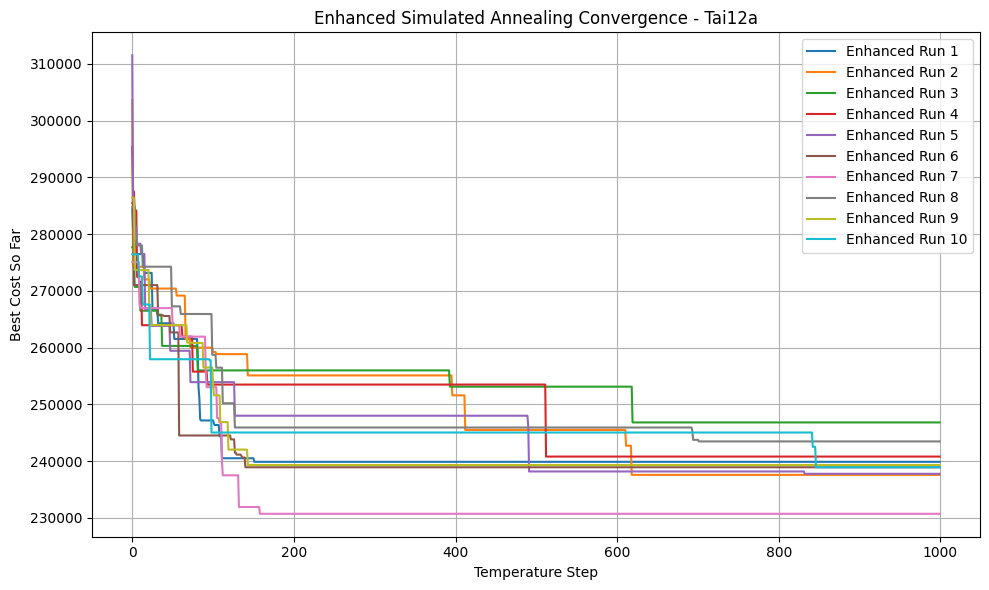

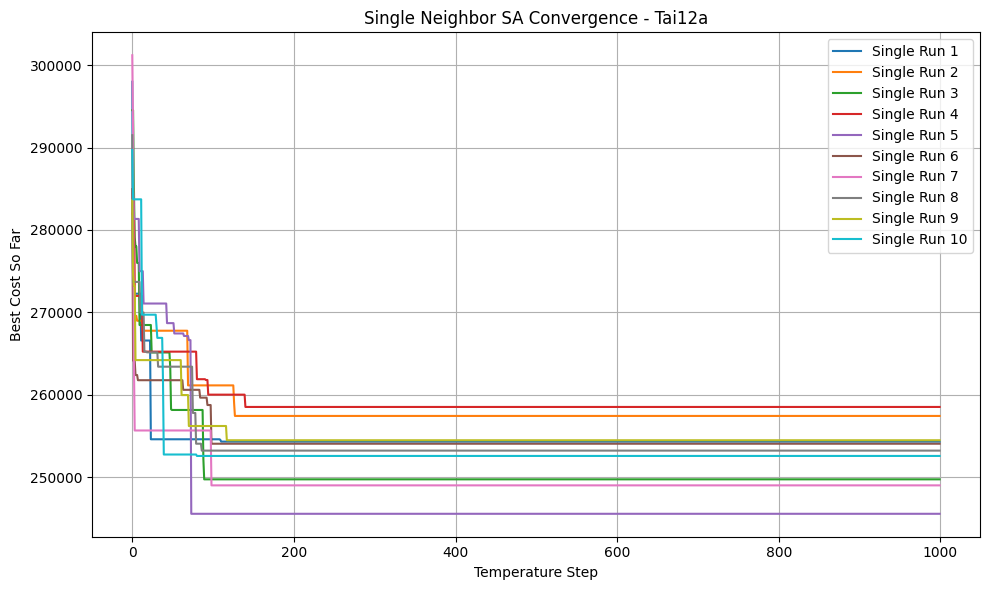

In [27]:
# --- Run the Algorithm 10 Times ---
problem_name = "Tai12a"
problem_size = distance_matrix.shape[0]

# Store results separately for both SA variants
results_single = []
results_enhanced = []
convergence_single = []
convergence_enhanced = []

# --- SA Parameters ---
T0 = 100000
alpha = 0.97
beta = 100  # Only used for linear cooling
Mk = 20
max_temp_loops = 1000
cooling_method = 'default'  # Options: 'default', 'linear', 'logarithmic'

# --- Run 10 times for both SA variants ---
for run in range(10):
    # Enhanced SA with multiple neighbors
    sol_e, cost_e, conv_e = enhanced_simulated_annealing(
        flow_matrix,
        distance_matrix,
        T0=T0,
        alpha=alpha,
        beta=beta,
        Mk=Mk,
        max_temp_loops=max_temp_loops,
        cooling=cooling_method
    )
    results_enhanced.append(cost_e)
    convergence_enhanced.append(conv_e)
    print(f"Enhanced SA - Run {run+1}: Best Cost = {cost_e:,}")

    # Standard SA with single neighbor
    sol_s, cost_s, conv_s = simulated_annealing_single_neighbor(
        flow_matrix,
        distance_matrix,
        T0=T0,
        alpha=alpha,
        beta=beta,
        Mk=Mk,
        max_temp_loops=max_temp_loops,
        cooling=cooling_method
    )
    results_single.append(cost_s)
    convergence_single.append(conv_s)
    print(f"Single Neighbor SA - Run {run+1}: Best Cost = {cost_s:,}")

# --- Summary Table Function ---
def print_summary_table(name, results):
    average = sum(results) / len(results)
    print(f"\n=== Summary Table: {name} ===")
    print("Algorithm\t" + "\t".join([f"R. {i+1}" for i in range(10)]) + "\tAverage")
    print(f"{name}\t" + "\t".join(f"{r:,}" for r in results) + f"\t{average:,.2f}")

print_summary_table("Enhanced SA", results_enhanced)
print_summary_table("Single Neighbor SA", results_single)

# --- Plot Convergence for Each SA Variant ---
plt.figure(figsize=(10, 6))
for i, conv in enumerate(convergence_enhanced):
    plt.plot(conv, label=f"Enhanced Run {i+1}")
plt.title(f"Enhanced Simulated Annealing Convergence - {problem_name}")
plt.xlabel("Temperature Step")
plt.ylabel("Best Cost So Far")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i, conv in enumerate(convergence_single):
    plt.plot(conv, label=f"Single Run {i+1}")
plt.title(f"Single Neighbor SA Convergence - {problem_name}")
plt.xlabel("Temperature Step")
plt.ylabel("Best Cost So Far")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()